Copy 1 es el fichero funcional pero con MOSFETs envejecidos leídos desde el excel importado (léase descripción en Copy 1).
La principal diferencia con esta versión es la limpieza de ciertas partes innecesarias
Otra diferencia es la introduccción de un factor de envejecimiento para no leer de Tabla MOSFET más allá del original
También se han eliminado variables enterradas.
Se han incluido las pérdidas de la bobina en el cálculo

Copy 2 es el fichero funcional pero los valores eficaces de los MOSFETs estaban mal calculados.
En esta versión, se calculan suponiendo un rizado por la bobina despreciable.

VERSION ACTUAL
Incluye mejoras en el cálculo de los valores eficaces y corrige una errata en el cáuclo de Iin en ciertas llamadas a función, que faltaba un paréntesis para dar el orden adecuado.

In [122]:

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import scipy.integrate as integrate
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.patches as patches
import random

import MOS_design as MD
import mag_design as MGD
import scipy
from scipy import interpolate
# Default value of display.max_rows is 10 i.e. at max 10 rows will be printed.
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', None) #To show all values, not just 5
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(style="darkgrid")

In [123]:
# Seleccion de componentes y extracción de parámetros
# MOSFET data
MOSFETs=pd.read_excel(r'.\Space Components.xls',sheet_name="MOSFETs")
# Se usa del siguiente modo:
#MOSFETs['Id (A @25oC)'][54]=70
pd.options.display.max_columns = None
display(MOSFETs.tail(20))


,Part,JEDEC Part,Manufacturer,Type,Vds (V),Id (A @25oC),Id (A @100oC),Rdson (ohms @25oC),Rdson (ohms @125oC),Ciss (pF),Coss (pF),Crss (pF),Qg (nC),Qgs (nC),Qgd (nC),td_on (ns),tr (ns),td_off (ns),tf (ns),Rth jc (oC/W),Rth jPCB (oC/W),Tj_max (oC),Package,Link,NOTES
52,FBS-GAM02-P-R50,NaN,Freebird Semiconductor /EPC Space,3.0,50,10,7.5,0.007,0.01,NP,NP,NP,NP,NP,NP,60,6.5,75,6,8.5,NP,130,18 pin SMT,https://epc.space/documents/datasheets/FBSGAM0...,Half bridge plus driver. Seem to be EPC. Simil...
53,GS66516B,NaN,GaN Systems,2.0,650,60,47,0.025,0.065,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
54,IXTA26P20P,NaN,IXYS,1.0,200,70,26,0.17,0.34,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
55,GS66516B_old1,NaN,GaN Systems,2.0,650,60,47,0.0255,0.0663,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
56,IXTA26P20P_old1,NaN,IXYS,1.0,200,70,26,0.1734,0.3468,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
57,GS66516B_old2,NaN,GaN Systems,2.0,650,60,47,0.026,0.0676,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
58,IXTA26P20P_old2,NaN,IXYS,1.0,200,70,26,0.1768,0.3536,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
59,GS66516B_old3,NaN,GaN Systems,2.0,650,60,47,0.0265,0.0689,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN
60,IXTA26P20P_old3,NaN,IXYS,1.0,200,70,26,0.1802,0.3604,2740,540,100,56,18,20,18,33,46,21,0.42,0.5,125,NaN,NaN,NaN
61,GS66516B_old4,NaN,GaN Systems,2.0,650,60,47,0.027,0.0702,518,126,5.9,14.2,3.8,5.4,4.6,12.4,14.9,22,0.27,23,150,NaN,NaN,NaN


In [124]:
#MOSFETs.loc['GS66516B','Rdson (ohms @25oC)']
#MOSFETs.set_index('Part',inplace=True)

In [125]:
# float(MOSFETs.loc[MOSFETs['Part']=='GS66516B','Rdson (ohms @25oC)'])
# MOSFETs[MOSFETs['Part']=='GS66516B'].index[0]
# MOSFETs.loc[:,'Tj_max (oC)']

# Variables de entrada y configuración

In [126]:
Vbus=100 # Tensión en el bus
Vsa_min=80 #Máximo y minimo de la tensión del panel solar
Vsa_max=150
fsw=180e3 #100000 # Frecuencia de conmutación
T=1/fsw
P=500 # Potencia nominal
L_ind=84/1000000

size_D1=5 #Número de elementos en los vectores de D1 y D2.
size_D2=5

# Estos no son límites de operación, que vienen definidos por las variables de arriba. Estos son límites de representación
# de las gráficas como los mapas de calor.
D1_min_sh=0.1
D1_max_sh=1
D2_min_sh=0.0
D2_max_sh=0.7

D1_nom=0.8
D2_nom=0.1
D1_max=0.95
D2_min=0.05


phi_bob=0 #Desfase entre las señales de gobierno D1 y D2.
Lim_sup_D1=0.95 # Límites máximos de operación de los ciclos de trabajo
Lim_inf_D2=0.05

# MOSFET seleccionados en la implementación, según la tabla importada de Excel.
chosen_FET='GS66516B' 
M1_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M2_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M3_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M4_index=MOSFETs[MOSFETs['Part']==chosen_FET].index[0]
M1prot_index=MOSFETs[MOSFETs['Part']=='IXTA26P20P'].index[0]
M3prot_index=MOSFETs[MOSFETs['Part']=='IXTA26P20P'].index[0]
prot_on=1
#Características del driver de los MOSFETs (paera pérdidas de conmutación)
Vdrvr=9
Idrvr=4

Rca_M1=3.2#based on excel file
Rjc_M1=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M2=3.2
Rjc_M2=1.5#Based on aplication note and datasheet that includes IMS and the rest MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M3=3.2
Rjc_M3=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rca_M4=3.2
Rjc_M4=1.5#MOSFETs.loc[M1_index,MOSFETs['Rth jc (oC/W)']]
Rjc_M1prot=MOSFETs.loc[M1prot_index,'Rth jc (oC/W)']
Rca_M1prot=8.5/2
Rjc_M3prot=MOSFETs.loc[M3prot_index,'Rth jc (oC/W)']
Rca_M3prot=8.5/2

Tjmax_M1=MOSFETs.loc[M1_index,'Tj_max (oC)']
Tjmax_M2=MOSFETs.loc[M2_index,'Tj_max (oC)']
Tjmax_M3=MOSFETs.loc[M3_index,'Tj_max (oC)']
Tjmax_M4=MOSFETs.loc[M4_index,'Tj_max (oC)']
Tjmax_M1prot=MOSFETs.loc[M1prot_index,'Tj_max (oC)']
Tjmax_M3prot=MOSFETs.loc[M3prot_index,'Tj_max (oC)']

Tini=25 #ambient temperature

# Máximo envejecimiento
aging_n=1 #no aging
aging=1.1 #Sólo como ejemplo en ciertas partes.
max_age=1.12
aging_extra=1.2

aging_max=0.12 # Tanto por uno. FIjado según artículo de DUsmez Remaining useful...
aging_steps=6 #Número de muestras a la hora de construir la base de datos
elements=30 # Núemro de muestras tomadas en la curva de péridas en función de la ganancia

error_sense=50.0 # en tanto por mil

# Del material magnético y el núcleo se fija un E30/15/7 3F3
c_ind=6.198/10000000000000
x_ind=1.721
y_ind=2.736
Vol_ind=0.000004
N_ind=40
Ae_ind=0.00006
fw_ind=0.3
WA_ind=0.00009
lm_ind=0.056
rho=1/57000000
Awire_ind=WA_ind*fw_ind/N_ind
Lwire_ind=N_ind*lm_ind

In [127]:
# MOSFETs.loc[M1prot_index,'Rth jc (oC/W)']

# Funciones operación convertidor

In [128]:
#REVISAR EL ARTÏCULO Online Health Monitoring in Digitally Controlled Power Converters


In [129]:
#https://realpython.com/linear-regression-in-python/#what-is-regression

In [130]:
##FUNCTIONS MODIFIED
# 
#  GANANCIA ESTÁTICA, TENSIÓN DE SALIDA ESTÁTICA
def Gain(D1,D2):
    return D1/(1-D2)

def Vin_f(Vout,D1,D2):
    return Vout*(1-D2)/D1

def D2_f(Vin,Vout,D1):
    return 1-Vin/Vout*D1

def D1_f(Vin,Vout,D2):
    return (1-D2)*Vout/Vin


# EVOLUCIÓN DE CORRIENTES POR INTERVALOS

# Este primer período siempre es igual
def Ip1(t,L,Vin,Vout,I1,phi,D1,D2):
    return I1+(Vin-Vout)*t/L

#El segundo período depende de phi+D2 respecto a D1 en su límite de validez, pero no en la ecuación.
def Ip2(t,L,Vin,Vout,I2,phi,D1,D2):
    return np.where(phi<D1,I2+Vin*t/L,I2-Vout*t/L)
    # if (phi<D1):
    #     return I2+Vin*t/L
    # else:
    #     return I2-Vout*t/L

#El tercer período depende de phi+D2 respecto a D1. 
def Ip3(t,L,Vin,Vout,I3,phi,D1,D2):
    return np.where(phi+D2<D1,I3+(Vin-Vout)*t/L,I3+t*0)
    # if phi+D2<D1:
    #     return I3+(Vin-Vout)*t/L
    # else:
    #     return I3+t*0

# Este último período siempre es igual
def Ip4(t,L,Vin,Vout,I4,phi,D1,D2):
    return I4-Vout*t/L



# DEFINICIÓN DE INTERVALOS DE TIEMPO DE CADA PERIODO
# Son funciones auxiliares empleadas por la siguiente función. Generan conjuntos de puntos. Es en general,
#no solo para este caso de 4-switch buuck-boost

def t1(D1,D2,phi,T):
    return np.where(phi<D1,np.linspace(0,T*phi),np.linspace(0,T*D1))

def t2(D1,D2,phi,T):
    return np.where(phi>D1,np.linspace(T*D1,T*phi),np.where(D2+phi>D1,np.linspace(T*phi,D1*T),np.linspace(T*phi,(D2+phi)*T)))


def t3(D1,D2,phi,T):
    return np.where(phi>D1,np.linspace(T*phi,(D2+phi)*T),np.where(D2+phi>D1,np.linspace(D1*T,(D2+phi)*T),np.linspace((D2+phi)*T,D1*T)))

def t4(D1,D2,phi,T):
    return np.where( D2+phi>D1,np.linspace((D2+phi)*T,T),np.linspace(D1*T,T))

    

# Esta función devuelve los intervalos de tiempo t1 a t4 y los valores de comienzo y de final dedichos intervalos.
#Es decir, devuelve 12 elementos, agrupados de 3 en 3. 
# Validada de forma indirecta mediante la ecuación Iind_avg. SE DEBE MEJORAR LA VALIDACIÓN
def intervals(D1,D2,phi,T):
    t1_x=t1(D1,D2,phi,T).T
    df1=pd.DataFrame(t1_x)
    columns=['t1_'+str(i) for i in range(df1.shape[1])]
    df1.columns=columns
    t1_ini=t1_x[:,0]
    df1['t1_ini']=t1_ini
    t1_end = t1_x[:,- 1]
    df1['t1_end']=t1_end

    t2_x=t2(D1,D2,phi,T).T
    t2_ini=t2_x[:,0]
    t2_end = t2_x[:,- 1]
    df2=pd.DataFrame(t2_x)
    columns=['t2_'+str(i) for i in range(df2.shape[1])]
    df2.columns=columns
    df2['t2_ini']=t2_ini
    df2['t2_end']=t2_end

    t3_x=t3(D1,D2,phi,T).T
    t3_ini=t3_x[:,0]
    t3_end = t3_x[:,- 1]
    df3=pd.DataFrame(t3_x)
    columns=['t3_'+str(i) for i in range(df3.shape[1])]
    df3.columns=columns   
    df3['t3_ini']=t3_ini
    df3['t3_end']=t3_end

    t4_x=t4(D1,D2,phi,T).T
    t4_ini=t4_x[:,0]
    t4_end = t4_x[:,- 1]    
    df4=pd.DataFrame(t4_x)

    columns=['t4_'+str(i) for i in range(df4.shape[1])]
    df4.columns=columns
    df4['t4_ini']=t4_ini
    df4['t4_end']=t4_end
    tdf=pd.concat([df1,df2,df3,df4],axis='columns')
    return t1_x,t1_ini,t1_end,t2_x,t2_ini,t2_end,t3_x,t3_ini,t3_end,t4_x,t4_ini,t4_end,tdf
    

# VALORES DE CORRIENTE MEDIA, DE COMIENZO, ETC

# Valor medio de corriente por bobina
# Se debe indicar los valores de corriente al comienzo de cada intervalo y la duración de cada uno de dichos intervalos
# OK Validada en el ejemplo, lo que de forma indirecta valida también la ecuación anterior.
def Iind_avg(I1_ini,I2_ini,I3_ini,I4_ini,T1,T2,T3,T4):
    return 0.5*((I1_ini)*(T4+T1)+I2_ini*(T1+T2)+I3_ini*(T2+T3)+I4_ini*(T3+T4))/(T1+T2+T3+T4)


# Valor final de cada intervalo de corriente por la bobina
# Se debe dar la bobina, tensiones de entrada y salida, el valor de comienzo del periodo I1_ini, ciclos de trabajo,
# desfase y periodo

def currents(L,Vin,Vout,I1_ini,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=I1_ini
    Ip1_end=Ip1(t[2],L,Vin,Vout,I1_ini,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    ipdf=pd.DataFrame({'Ip1_end':Ip1_end,'Ip2_end':Ip2_end,'Ip3_end':Ip3_end,'Ip4_end':Ip4_end})
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end,ipdf

# Corriente inicial del periodo (no de un intervalo):
def Iini(L,Vin,Iin,Vout,D1,D2,phi,T):
    c=currents(L,Vin,Vout,0,D1,D2,phi,T)
    # print(pd.DataFrame(c))
    i=intervals(D1,D2,phi,T)
    A1=np.where(c[3]>0,0.5*(c[0]-0)*(i[2]-i[1])+0.5*np.abs(c[1]+c[0])*(i[5]-i[4])+np.minimum(c[0],c[1])*(i[5]-i[4])+0.5*np.abs(c[2]-c[1])*(i[8]-i[7])+np.minimum(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10]),0.5*(c[0]-0)*(i[2]-i[1])+0.5*np.abs(c[1]+c[0])*(i[5]-i[4])+np.minimum(c[0],c[1])*(i[5]-i[4])+0.5*np.abs(c[2]-c[1])*(i[8]-i[7])+np.minimum(c[2],c[1])*(i[8]-i[7])+0.5*c[2]*(i[11]-i[10]))

    Iini=Iin/D1-A1/T
    return Iini

# Se basa en la anterior, current function, pero sin dar valor inicial
def currents_L(L,Vin,Vout,Iin,D1,D2,phi,T):
    t=intervals(D1,D2,phi,T)
    Ip4_end=Iini(L,Vin,Iin,Vout,D1,D2,phi,T)
    Ip1_end=Ip1(t[2],L,Vin,Vout,Ip4_end,phi,D1,D2)
    Ip2_end=Ip2(t[5]-t[2],L,Vin,Vout,Ip1_end,phi,D1,D2)
    Ip3_end=Ip3(t[8]-t[5],L,Vin,Vout,Ip2_end,phi,D1,D2)
    ipdf=pd.DataFrame({'Ip1_end':Ip1_end,'Ip2_end':Ip2_end,'Ip3_end':Ip3_end,'Ip4_end':Ip4_end})
    return Ip1_end,Ip2_end,Ip3_end,Ip4_end,ipdf

# Valor eficaz y valor medio de un intervalo (no del período completo)
def Irms_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=(Ifin-Iini)
    return np.sqrt(fsw*(Iini**2*dt+Iini*dI*dt+dI**2*dt/3))

def Iavg_sec(fsw,tfin,tini,Ifin,Iini):
    dt=tfin-tini
    dI=Ifin-Iini
    return 0.5*(Iini+Ifin)*(tfin-tini)*fsw

def Irms_Mi(D1,D2,phi,fsw,tfin1,tfin2,tfin3,tfin4,tini1,Ifin1,Ifin2,Ifin3,Ifin4):
    Irms_M1=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2),np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2))
    Irms_M2=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2),np.sqrt(Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2))
    Irms_M3=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2),np.sqrt(Irms_sec(fsw,tfin1,tini1,Ifin1,Ifin4)**2+Irms_sec(fsw,tfin4,tfin3,Ifin4,Ifin3)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2))
    Irms_M4=np.where(phi+D2>D1,np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2+Irms_sec(fsw,tfin3,tfin2,Ifin3,Ifin2)**2),np.sqrt(Irms_sec(fsw,tfin2,tfin1,Ifin2,Ifin1)**2))
        
    return Irms_M1,Irms_M2,Irms_M3,Irms_M4


In [131]:
def R_interpol (M_i,temp):
    R25=float(MOSFETs.loc[M_i,'Rdson (ohms @25oC)'])# If Part is set as index then it could be used: Dataframe.loc[MOSFET_NAME,'Rdson (ohms @25oC)']
    R125=float(MOSFETs.loc[M_i,'Rdson (ohms @125oC)'])#Dataframe.loc[MOSFET_NAME,'Rdson (ohms@125oC)'] it means @ tj max but keep for consistency
    # print(R25,R125)
    temp_value = np.array([25,MOSFETs.loc[M_i,'Tj_max (oC)']])
    R_value = np.array([R25,R125])
    R_interp = scipy.interpolate.interp1d(temp_value, R_value,kind="slinear")
    temp_new = np.linspace(25, 125, 1000)
    return R_interp(temp)

def cond_losses_temp(sw_losses,cond_losses25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    cond_losses=cond_losses25*np.ones(df.shape[0])

    losses=sw_losses+cond_losses25

    temp=(Tini)*np.ones(df.shape[0])
    temp_end=temp+0.02
    for i in range (df.shape[0]):
        while ((temp_end[i])>temp[i]+0.01 or (temp_end[i])<temp[i]-0.01):
            # print('temp_end-temp',temp_end-temp)
            temp[i]=temp[i]+0.01#incr_temp
            # print('temp_end',temp_end)
            cond_losses[i]=MD.cond_losses(aging*R_interpol(M_i,temp[i]),Irms[i]) 
            # print('cond', cond_losses[i])  
            # print('sw_losses',sw_losses[i])
            # print(cond_losses[i]+sw_losses[i])
            losses[i]=sw_losses[i]+cond_losses[i]
            # print('losses_tot',losses)
            temp_end[i]=Tini+losses[i]*(Rjc+Rca)
            # print ('tini',Tini)
            # print(losses[i]*(Rjc+Rca))
            if (temp_end[i]>Tmax):
                break
        # temp_final[i]=temp_end[i]

    return cond_losses, temp_end#,losses
    
# cond_losses_temp(np.array(([1.0,1.0])),np.array([1.0,1.0]),53,5*np.array([1,1]),1.1,1,1,25,125,np.array([[1,1],[1,1]]))
# cond_losses_temp(np.array(([1.0,1.0])),np.array([1.0,1.0]),53,5*np.array([1,1]),1.1,1,1,25,125,np.array([[1,1],[1,1]]))

LOSSES 


In [132]:
#MOSFET de Buck
def Losses_M1(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
#Si no conmuta, sólo hay pérdidas de conducción
    losses_sw1=MD.sw_losses(Vin,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
    losses_sw=np.where((D1==1) | (D1==0),0,losses_sw1+losses_sw2+losses_sw3) 

    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms) 
    losses_cond,Temp_M1=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)

    # Temp_M1=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)[1]
    losses_tot=losses_sw+losses_cond
    Temp_M1=np.where((D1!=0),Temp_M1,Tini)
    return np.where(D1==1,losses_tot,np.where(D1==0,0,losses_tot)),Temp_M1

#     if (D1==1):
# # Si conmuta, hay pérdidas de conducción y conmutación. Además, este dispositivo no conmuta con ZVS en encenddo ni ZCS en apagado



# DIODO de Buck        
def Losses_M2(D1,Vin,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    losses_sw1=MD.sw_losses(Vin,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vin,fsw)
    losses_sw=np.where((D1==1) | (D1==0),0,losses_sw1+losses_sw2+losses_sw3)
    
    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_cond,Temp_M2=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)
    
    losses_tot=losses_sw+losses_cond
    Temp_M2=np.where((D1==1)|(D1==0),Tini,Temp_M2)

    return np.where((D1==1)|(D1==0),0,losses_tot),Temp_M2
# # there's trun on ZVS 


    
#DIODO de Boost
def Losses_M3(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):

    losses_sw1=MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
    losses_sw=np.where((D2==1)|(D2==0),0,losses_sw1+losses_sw2+losses_sw3)
    
    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)
    losses_cond,Temp_M3=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)

    losses_tot=losses_sw+losses_cond
    Temp_M3=np.where(D2!=1,Temp_M3,Tini)

    return np.where(D2==0,losses_tot,np.where(D2==1,0,losses_tot)),Temp_M3

# # If it's switching there are conduction and switching losses. besides there's ZVS

    
#MOSFET de Boost 
def Losses_M4(D2,Vout,Ion,Ioff,fsw,M_i,Vdr,Idr,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    losses_sw1=MD.sw_losses(Vout,Ion,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)+MD.sw_losses(Vout,Ioff,fsw,MOSFETs['Qg (nC)'][M_i]*10**-9,Idr)
    losses_sw2=MD.gate_sw_losses(MOSFETs['Qg (nC)'][M_i]*10**-9,Vdr,fsw)
    losses_sw3=MD.Coss_sw_losses(MOSFETs['Coss (pF)'][M_i]*10**-12,Vout,fsw)
    losses_sw=np.where((D2==1) | (D2==0),0,losses_sw1+losses_sw2+losses_sw3)
    
    losses_cond25=MD.cond_losses(aging*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms)

    losses_cond,Temp_M4=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)
   
    losses_tot=losses_sw+losses_cond  
    Temp_M4=np.where((D2==0) | (D2==1),Tini,Temp_M4)

    return np.where((D2==0) | (D2==1),0,losses_tot),Temp_M4
#If it switches, there are conduction and switching losses. No ZVS and no ZCS


    

def Losses_prot(M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df):
    
    losses_sw=0*np.ones(df.shape[0])
    losses_cond25=MD.cond_losses(aging/2*MOSFETs['Rdson (ohms @25oC)'][M_i],Irms) # divided by 2 due to being two in parallel
    
    losses_cond,Temp_Mprot=cond_losses_temp(losses_sw,losses_cond25,M_i,Irms,aging,Rjc,Rca,Tini,Tmax,df)   

    losses_tot=losses_cond+losses_sw
    
    return losses_tot,Temp_Mprot


def Losses_ind(c,x,y,Vol,fsw,L,Iac,N,Ae,Irms,Awire,Lwire,rho):
    Bac=L*Iac/2/N/Ae*1000
    losses_sw=MGD.core_losses(c,x,y,Bac,fsw,Vol)
    losses_cond=MGD.copper_losses(Irms,Awire,Lwire,rho)
    return losses_cond+losses_sw




# typical values c,x,y
(6.198074738669944, 1.7205492791242043, 2.736106449242652)
A=Losses_ind(6.198/10000000000000, 1.721, 2.736,0.000004,180000,84/1000000,6.61,40,0.00006,5.35,0.00009*0.3/40,40*0.056,1/57000000)


HEATMAP

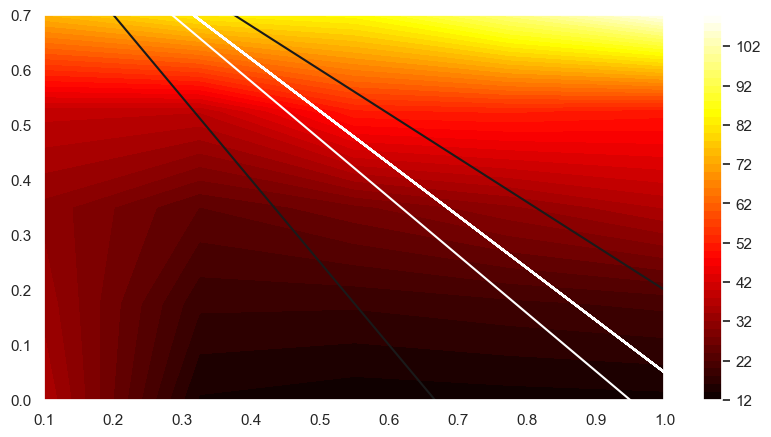

12

In [134]:
D1_r=np.linspace(D1_min_sh,D1_max_sh,size_D1)
D2_r=np.linspace(D2_min_sh,D2_max_sh,size_D2)
from itertools import product
from typing import ValuesView
values = np.array(list(product(D1_r,D2_r))) #to get all possible combinations

df_hm=pd.DataFrame(values)
df_hm.columns=['D1','D2']
D1_r=df_hm.loc[:,'D1']
D2_r=df_hm.loc[:,'D2']
phi=0
phi_bob=phi*np.ones(df_hm.shape[0])
fsw=180e3
T=1/fsw
P=500
Vbus=100
L_ind=83.5e-6
# df_hm['D1']=D1_r
# df_hm['D2']=D2_r
df_hm['Gain']=D1_r/(1-D2_r)
df_hm['phi']=phi_bob*np.ones(df_hm.shape[0])
df_hm['T']=T*np.ones(df_hm.shape[0])
df_hm['fsw']=fsw*np.ones(df_hm.shape[0])
df_hm['L']=L_ind*np.ones(df_hm.shape[0])
df_hm['Vin']=Vbus*np.ones(df_hm.shape[0])/df_hm.loc[:,'Gain']
df_hm['Vbus']=Vbus*np.ones(df_hm.shape[0])
df_hm['P']=P*np.ones(df_hm.shape[0])
df_hm['Iin(A)']=P/(Vbus/df_hm.loc[:,'Gain'])

fig, ax = plt.subplots()

c=currents_L(df_hm['L'],df_hm['Vin'],Vbus,df_hm['Iin(A)'],D1_r,D2_r,phi_bob,T)
interv=intervals(D1_r,D2_r,phi_bob,T)
# intervdf=pd.DataFrame(interv[-1])
df_hm_los=df_hm.copy()

Irms_M1,Irms_M2,Irms_M3,Irms_M4=Irms_Mi(D1_r,D2_r,phi_bob,fsw,interv[2],interv[5],interv[8],interv[11],interv[1],c[0],c[1],c[2],c[3])
aux_M1,Temp_M1=Losses_M1(D1_r,Vin_f(Vbus,D1_r,D2_r),c[3],c[1],fsw,M1_index,Vdrvr,Idrvr,Irms_M1,aging_n,Rjc_M1,Rca_M1,Tini,Tjmax_M1,df_hm_los)
aux_M2,Temp_M2=Losses_M2(D1_r,Vin_f(Vbus,D1_r,D2_r),c[1],c[3],fsw,M2_index,Vdrvr,Idrvr,Irms_M2,aging_n,Rjc_M2,Rca_M2,Tini,Tjmax_M2,df_hm_los)
aux_M3,Temp_M3=Losses_M3(D2_r,Vbus,c[2],c[0],fsw,M3_index,Vdrvr,Idrvr,Irms_M3,aging_n,Rjc_M3,Rca_M3,Tini,Tjmax_M3,df_hm_los)
aux_M4,Temp_M4=Losses_M4(D2_r,Vbus,c[0],c[2],fsw,M4_index,Vdrvr,Idrvr,Irms_M4,aging_n,Rjc_M4,Rca_M4,Tini,Tjmax_M4,df_hm_los)
aux_protM3,Temp_protM3=Losses_prot(M3prot_index,Irms_M3,aging_n,Rjc_M3prot,Rca_M3prot,Tini,Tjmax_M3prot,df_hm_los)
aux_protM1,Temp_protM1=Losses_prot(M1prot_index,Irms_M1,aging_n,Rjc_M1prot,Rca_M1prot,Tini,Tjmax_M1prot,df_hm_los)

Iac_ind=c[-1].max(axis=1)-c[-1].min(axis=1) #Validated with other implementation. Works
df_hm_los['Iac_ind']=Iac_ind

Iavg_ind=Iind_avg(c[3],c[0],c[1],c[2],interv[2]-interv[1],interv[5]-interv[4],interv[8]-interv[7],interv[11]-interv[10])

Irms1=Irms_sec(1/T,interv[2],interv[1],c[0],c[3])
Irms2=Irms_sec(1/T,interv[5],interv[4],c[1],c[0])
Irms3=Irms_sec(1/T,interv[8],interv[7],c[2],c[1])
Irms4=Irms_sec(1/T,interv[11],interv[10],c[3],c[2])
Irms_ind=np.sqrt(Irms1**2+Irms2**2+Irms3**2+Irms4**2)

df_hm_los['Irms_ind']=Irms_ind
df_hm_los['Ipk_ind']=c[-1].max(axis=1)
df_hm_los['Iavg']=(c[-1].max(axis=1)+c[-1].min(axis=1))/2
aux_L=Losses_ind(c_ind,x_ind,y_ind,Vol_ind,fsw,L_ind,Iac_ind,N_ind,Ae_ind,Irms_ind,Awire_ind,Lwire_ind,rho)

aux=aux_M1+aux_M2+aux_M3+aux_M4+aux_L+aux_protM1+aux_protM3
losses=aux

df_hm_los['losses M1']=aux_M1
df_hm_los['losses M2']=aux_M2
df_hm_los['losses M3']=aux_M3
df_hm_los['losses M4']=aux_M4
df_hm_los['losses L']=aux_L
df_hm_los['losses M1 prot']=aux_protM1
df_hm_los['Losses M3 prot']=aux_protM3
df_hm_los['Losses']=losses
df_hm_los['Temp_M1']=Temp_M1
df_hm_los['Temp_M2']=Temp_M2
df_hm_los['Temp_M3']=Temp_M3
df_hm_los['Temp_M4']=Temp_M4
df_hm_los['Temp_M1prot']=Temp_protM1
df_hm_los['Temp_M3prot']=Temp_protM3

heat=df_hm_los.loc[:,['D1','D2','Losses']]
heat=heat.set_index('D2')
heat=heat.pivot(columns='D1')
heat_val=heat.values
D1_x=heat.columns.get_level_values(1)
D2_y=heat.index.values


#Plot the surface.
gr=ax.contourf(D1_x, D2_y, heat_val, 50, cmap='hot')#,vmin=6.9,vmax=30)  #'RdYlBu'
cbar=fig.colorbar(gr)
# ticklabs = cbar.ax.get_yticklabels()
# cbar.ax.set_yticklabels(ticklabs, fontsize=20)
# fig.canvas.toolbar_visible = True
# fig.canvas.header_visible = True
# fig.canvas.resizable = True

# Black lines -> max and min gain
ax.plot(D1_r,D2_f(Vsa_max,Vbus,D1_r),'k')
ax.plot(D1_r,D2_f(Vsa_min,Vbus,D1_r),'k')

# White lines-> limit the duty cyles due to dead times

ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(D1_min_sh,D1_max_sh)
plt.ylim(D2_min_sh,D2_max_sh)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)


plt.show()
12 

In [ ]:
df_hm_los

,D1,D2,Gain,phi,T,fsw,L,Vin,Vbus,P,Iin(A)
0,0.100,0.000,0.100000,0.0,0.000006,180000.0,0.000083,1000.000000,100.0,500.0,0.500000
1,0.100,0.175,0.121212,0.0,0.000006,180000.0,0.000083,825.000000,100.0,500.0,0.606061
2,0.100,0.350,0.153846,0.0,0.000006,180000.0,0.000083,650.000000,100.0,500.0,0.769231
3,0.100,0.525,0.210526,0.0,0.000006,180000.0,0.000083,475.000000,100.0,500.0,1.052632
4,0.100,0.700,0.333333,0.0,0.000006,180000.0,0.000083,300.000000,100.0,500.0,1.666667
5,0.325,0.000,0.325000,0.0,0.000006,180000.0,0.000083,307.692308,100.0,500.0,1.625000
6,0.325,0.175,0.393939,0.0,0.000006,180000.0,0.000083,253.846154,100.0,500.0,1.969697
7,0.325,0.350,0.500000,0.0,0.000006,180000.0,0.000083,200.000000,100.0,500.0,2.500000
8,0.325,0.525,0.684211,0.0,0.000006,180000.0,0.000083,146.153846,100.0,500.0,3.421053
9,0.325,0.700,1.083333,0.0,0.000006,180000.0,0.000083,92.307692,100.0,500.0,5.416667


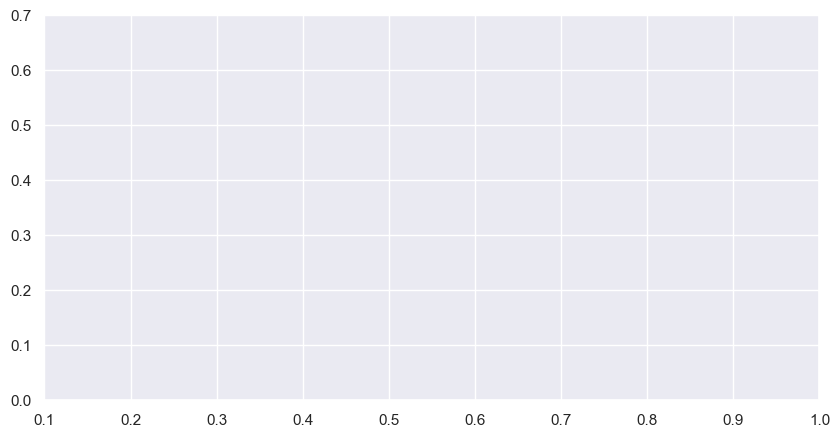

In [ ]:
#Plot the surface.
gr=ax.contourf(D1_x, D2_y, heat_val, 50, cmap='hot')#,vmin=6.9,vmax=30)  #'RdYlBu'
cbar=fig.colorbar(gr)


# Black lines -> max and min gain
ax.plot(D1_r,D2_f(Vsa_max,Vbus,D1_r),'k')
ax.plot(D1_r,D2_f(Vsa_min,Vbus,D1_r),'k')

# White lines-> limit the duty cyles due to dead times

ax.plot(D1_r,D2_f(Vbus,Lim_sup_D1*Vbus,D1_r),'w')
ax.plot(D1_f(Vbus*(1-Lim_inf_D2),Vbus,D2_r),D2_r,'w')


#ax.plot(D1_r,D2_r,'g')
plt.xlim(D1_min_sh,D1_max_sh)
plt.ylim(D2_min_sh,D2_max_sh)
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# f = plt.figure()
# f.set_figwidth(20)
# f.set_figheight(10)

plt.show()
